In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import matplotlib.pyplot as plt
import matplotlib
from torch.autograd import Variable

import torch.nn.functional as F
import numpy as np

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          download=True)

In [ ]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

# Model

In [ ]:
# Convolutional neural network (two convolutional layers)
class ConvNet_Base(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet_Base, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(7*7*32, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.softmax(self.fc2(out))
        return out

In [ ]:
# Convolutional neural network (two convolutional layers)
class ConvNet_Layer(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet_Layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(7*7*32, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x, training_layer = 'fc2'):
        if training_layer == 'layer1':
            x = self.layer1(x)
          
        elif training_layer == 'layer2': 
            x = self.layer1(x)
            x = self.layer2(x)
            x = x.reshape(x.size(0), -1)
          
        elif training_layer == 'fc1':
            x = self.layer1(x)
            x = self.layer2(x)
            x = x.reshape(x.size(0), -1)
            x = torch.tanh(self.fc1(x))
          
        elif training_layer == 'fc2':

            x = self.layer1(x)
            x = self.layer2(x)
            x = x.reshape(x.size(0), -1)
            x = torch.tanh(self.fc1(x))
            x = F.softmax(self.fc2(x), dim=1)
      
        return x

# Evaluation

In [ ]:
def plot_loss(layer1, epoche, loss_type):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train "+ loss_type)
    plt.xlabel("epoch")
    plt.ylabel(loss_type)
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, layer1)
    #plt.plot(epoche_range, layer2)
    #plt.plot(epoche_range, fc)
    #plt.legend(['train loss', 'validation loss'], loc='best')
    plt.show()

def plot_acc(train, test, epoche):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train and validation Accuarcy")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, train)
    plt.plot(epoche_range, test)
    #plt.plot(epoche_range, fc)
    plt.legend(['train accuracy', 'test accuracy'], loc='best')
    plt.show()

def eval(model, isprint=True):
    model.eval()
    with torch.no_grad():
        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images = images.float().to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
    
        train_acc = train_correct/train_total
    
    with torch.no_grad():
        test_correct = 0
        test_total = 0
        for images, labels in test_loader:
            images = images.float().to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    
        test_acc = test_correct/test_total

    if isprint:
        print('Accuracy of the network on the train: {} %'.format(100 * train_acc))
        print('Accuracy of the network on the test: {} %'.format(100 * test_acc))
    
    return train_acc, test_acc 

# MINE

In [ ]:
import math

torch.autograd.set_detect_anomaly(True)

EPS = 1e-6

class EMALoss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, running_ema):
        ctx.save_for_backward(input, running_ema)
        input_log_sum_exp = input.exp().mean().log()

        return input_log_sum_exp

    @staticmethod
    def backward(ctx, grad_output):
        input, running_mean = ctx.saved_tensors
        grad = grad_output * input.exp().detach() / \
            (running_mean + EPS) / input.shape[0]
        return grad, None


def ema(mu, alpha, past_ema):
    return alpha * mu + (1.0 - alpha) * past_ema


def ema_loss(x, running_mean, alpha):
    t_exp = torch.exp(torch.logsumexp(x, 0) - math.log(x.shape[0])).detach()
    if running_mean == 0:
        running_mean = t_exp
    else:
        running_mean = ema(t_exp, alpha, running_mean.item())
    t_log = EMALoss.apply(x, running_mean)

    # Recalculate ema

    return t_log, running_mean

class ConcatLayer(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, x, y):
        x = x.view(x.shape[0], -1)
        y = y.view(y.shape[0], -1)
        return torch.cat((x, y), self.dim)


class CustomSequential(nn.Sequential):
    def forward(self, *input):
        for module in self._modules.values():
            if isinstance(input, tuple):
                input = module(*input)
            else:
                input = module(input)
        return input

class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)

        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])

        return -t + second_term

In [ ]:
# methods to approximate the functional T

class T(nn.Module):
    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.layers = CustomSequential(ConcatLayer(), nn.Linear(x_dim + z_dim, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 1))

    def forward(self, x, z):
        return self.layers(x, z)

class GaussianLayer(nn.Module):
    def __init__(self, std, device):
        super().__init__()
        self.std = std
        self.device = device

    def forward(self, x):
        return x + self.std * torch.randn_like(x).to(self.device)

class StatisticsNetwork(nn.Module):
    def __init__(self, x_dim, z_dim, device):
        super().__init__()
        self.layers = nn.Sequential(
            GaussianLayer(std=0.3, device=device),
            nn.Linear(x_dim + z_dim, 512),
            nn.ELU(),
            GaussianLayer(std=0.5, device=device),
            nn.Linear(512, 512),
            nn.ELU(),
            GaussianLayer(std=0.5, device=device),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        return self.layers(x)

class ConvolutionalStatisticsNetwork(nn.Module):
    def __init__(self, num_x_channel, z_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(num_x_channel, 16, kernel_size=5,
                               stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5,
                               stride=2, padding=2, bias=False)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5,
                               stride=2, padding=2, bias=False)

        self.fc1 = nn.Linear(4 * 4 * 64, 1)

        self.z_linear1 = nn.Linear(z_dim, 16)
        self.z_linear2 = nn.Linear(z_dim, 32)
        self.z_linear3 = nn.Linear(z_dim, 64)

    def xz_block(self, x, z, x_layer, z_layer):
        x_out = x_layer(x)
        z_map = z_layer(z).unsqueeze(-1).unsqueeze(-1).expand_as(x_out)
        #print(x_out.shape, z_map.shape)
        return F.elu(x_out + z_map)

    def forward(self, x, z):
        z = z.view(z.shape[0], -1)
        x = self.xz_block(x, z, self.conv1, self.z_linear1)
        x = self.xz_block(x, z, self.conv2, self.z_linear2)
        x = self.xz_block(x, z, self.conv3, self.z_linear3)

        x = x.view(x.size(0), -1)
        return self.fc1(x)

In [ ]:
class DoubleConvolutionalStatisticsNetwork_layer1(nn.Module):
    def __init__(self, num_x_channel, num_z_channel):
        super().__init__()
        
        self.conv1 = nn.Conv2d(num_x_channel, 16, kernel_size=5, 
                               stride=2, padding=2, bias=False)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5,
                               stride=2, padding=2, bias=False)   
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5,
                               stride=2, padding=2, bias=False)   

        self.fc1 = nn.Linear(4 * 4 * 64, 1)

        self.z_conv1 = nn.Conv2d(num_z_channel, 16, kernel_size=5,
                               stride=1, padding=2, bias=False)   
        self.z_conv2 = nn.Conv2d(16, 32, kernel_size=5,   
                               stride=2, padding=2, bias=False)   
        self.z_conv3 = nn.Conv2d(32, 64, kernel_size=5,
                               stride=2, padding=2, bias=False)
    def xz_block(self, x, z, x_layer, z_layer):
        x_out = x_layer(x)
        z_map = z_layer(z)

        return F.elu(x_out + z_map)

    def forward(self, x, z):
        x = self.xz_block(x, z, self.conv1, self.z_conv1)     
        z = self.z_conv1(z)
        x = self.xz_block(x, z, self.conv2, self.z_conv2)     
        z = self.z_conv2(z)
        x = self.xz_block(x, z, self.conv3, self.z_conv3)

        x = x.view(x.size(0), -1)
        return self.fc1(x)

class DoubleConvolutionalStatisticsNetwork_layer2(nn.Module):
    def __init__(self, num_x_channel, num_z_channel):
        super().__init__()
        self.conv1 = nn.Sequential(
                                nn.Conv2d(num_x_channel, 16, kernel_size=5, 
                                          stride=2, padding=2, bias=False),
                                nn.MaxPool2d(kernel_size=2, stride=2)  
                                ) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5,
                               stride=2, padding=2, bias=False)   
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5,
                               stride=2, padding=2, bias=False)   

        self.fc1 = nn.Linear(2 * 2 * 64, 1)

        self.z_conv1 = nn.Conv2d(num_z_channel, 16, kernel_size=5,
                               stride=1, padding=2, bias=False)   
        self.z_conv2 = nn.Conv2d(16, 32, kernel_size=5,   
                               stride=2, padding=2, bias=False)   
        self.z_conv3 = nn.Conv2d(32, 64, kernel_size=5,
                               stride=2, padding=2, bias=False)
    def xz_block(self, x, z, x_layer, z_layer):
        x_out = x_layer(x)
        z_map = z_layer(z)
        
        return F.elu(x_out + z_map)

    def forward(self, x, z):
        x = self.xz_block(x, z, self.conv1, self.z_conv1)     
        z = self.z_conv1(z)
        x = self.xz_block(x, z, self.conv2, self.z_conv2)     
        z = self.z_conv2(z)
        x = self.xz_block(x, z, self.conv3, self.z_conv3)

        x = x.view(x.size(0), -1)
        return self.fc1(x)

# Train

In [ ]:
def training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval = False):
    result_list = []
    total_step = len(train_loader)
    train_acc_list = []
    test_acc_list = []
    #if loss_type != "cross entropy":
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    for epoch in range(num_epochs):

    #print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
        sum_MI = 0
        model.train()
        mine.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
      
            # Forward pass
            outputs = model(images, training_layer=training_layer)
            if loss_type == '-MI(X;Z)':
                loss = mine(images, outputs).to(device)
            elif loss_type == '-MI(Y;Z)':
                labels = labels.view(labels.shape[0], -1).to(device) 
                loss = mine(labels, outputs).to(device)
            elif loss_type == "cross entropy":
                #labels = labels.view(labels.shape[0], -1).to(device) 
                loss = mine(outputs, labels).to(device)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #if loss_type != "cross entropy":
                #scheduler.step()
            MI = loss.item()
            sum_MI += MI
   
        avg_MI = sum_MI/total_step
        result_list.append(avg_MI)
        output = 'Epoch [{}/{}], '+ training_layer+' ' + loss_type +' : {:.12f}' 
        print (output.format(epoch+1, num_epochs, avg_MI))
        if iseval:
            if epoch == num_epochs-1:
                isprint = True
            else:
            isprint = False
            train_acc, test_acc = eval(model, isprint=isprint)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
    if len(train_acc_list) == num_epochs: 
        plot_acc(train_acc_list, test_acc_list, num_epochs)
  
    if iseval:
        return result_list, train_acc_list[-1], test_acc_list[-1]
    else:
        return result_list

# Flatten MINE

In [ ]:
def flatten_T_training(model, num_epochs, T, loss_list, layer_list, train_dataset):
    if len(train_dataset) < 1000:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
    else:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
 
    for param in model.parameters(): 
        param.requires_grad = False
  
    #training layer1
    print("Training layer1")
    for name, param in model.layer1.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[0]
    training_layer = layer_list[0]
    mine = Mine(T[0]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-5}])
    layer1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.layer1.named_parameters():
        param.requires_grad = False

    #training layer2
    print("Training layer2")
    for name, param in model.layer2.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[1]
    training_layer = layer_list[1]
    mine = Mine(T[1]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-5}])
    layer2 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.layer2.named_parameters():
        param.requires_grad = False

    #training fc1
    print("Training fc1")
    for name, param in model.fc1.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[2]
    training_layer = layer_list[2]
    mine = Mine(T[2]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-5}])
    fc1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.fc1.named_parameters():
        param.requires_grad = False

    #training fc2
    print("Training fc2")
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
    for name, param in model.fc2.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[3]
    training_layer = layer_list[3]
    mine = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    fc2, train_acc, test_acc = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval=True)
    for name, param in model.fc2.named_parameters():
        param.requires_grad = False
    return layer1, layer2, fc1, fc2, train_acc, test_acc

Training layer1
Epoch [1/500], layer1 -MI(X;Z) : -0.015218752452
Epoch [2/500], layer1 -MI(X;Z) : -0.074224882076
Epoch [3/500], layer1 -MI(X;Z) : -0.105680881441
Epoch [4/500], layer1 -MI(X;Z) : -0.114859762415
Epoch [5/500], layer1 -MI(X;Z) : -0.116587549821
Epoch [6/500], layer1 -MI(X;Z) : -0.117002958680
Epoch [7/500], layer1 -MI(X;Z) : -0.117117368430
Epoch [8/500], layer1 -MI(X;Z) : -0.116967861354
Epoch [9/500], layer1 -MI(X;Z) : -0.117041179662
Epoch [10/500], layer1 -MI(X;Z) : -0.117075405518
Epoch [11/500], layer1 -MI(X;Z) : -0.117233399798
Epoch [12/500], layer1 -MI(X;Z) : -0.117542678739
Epoch [13/500], layer1 -MI(X;Z) : -0.117236860966
Epoch [14/500], layer1 -MI(X;Z) : -0.117466066902
Epoch [15/500], layer1 -MI(X;Z) : -0.117565468202
Epoch [16/500], layer1 -MI(X;Z) : -0.117108909662
Epoch [17/500], layer1 -MI(X;Z) : -0.117409179856
Epoch [18/500], layer1 -MI(X;Z) : -0.117125577852
Epoch [19/500], layer1 -MI(X;Z) : -0.117315927645
Epoch [20/500], layer1 -MI(X;Z) : -0.117347

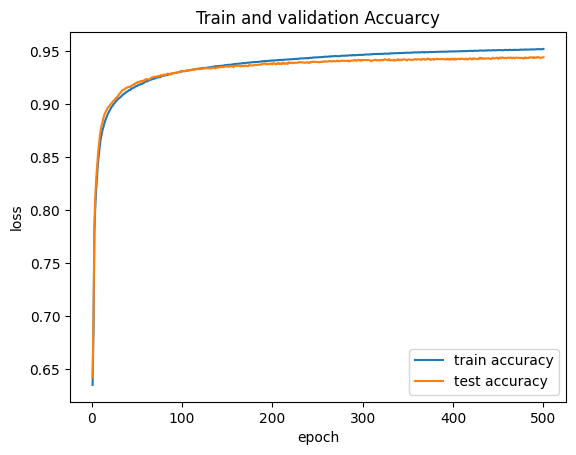

In [ ]:
model = ConvNet_Layer().to(device)
T_estimator = [T(28*28, 16*14*14), T(28*28, 32*7*7), T(1, 256)]
loss_list = ['-MI(X;Z)', '-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ["layer1", "layer2", 'fc1', 'fc2']
num_epochs = 500
layer1, layer2, fc1, fc2, _, _ = flatten_T_training(model, num_epochs, T_estimator, loss_list, layer_list, train_dataset)

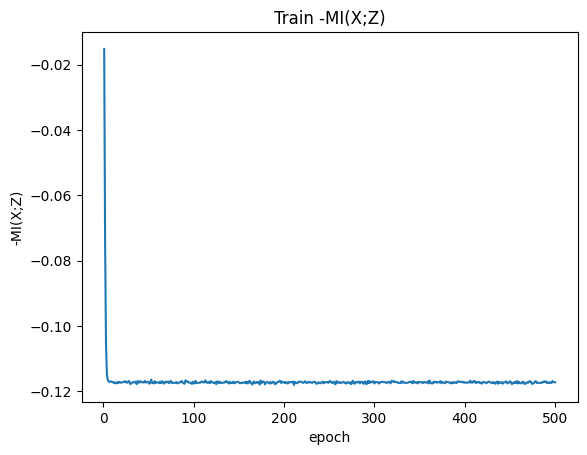

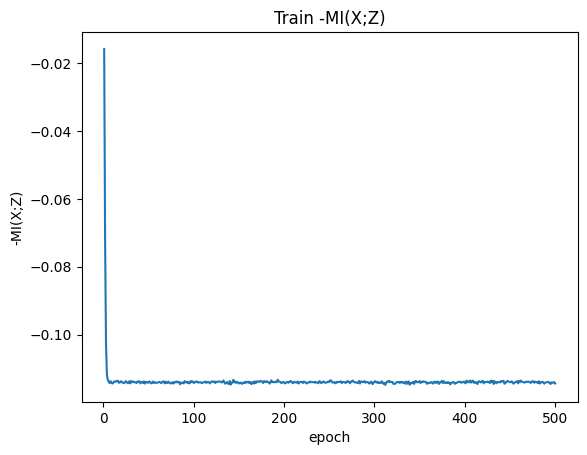

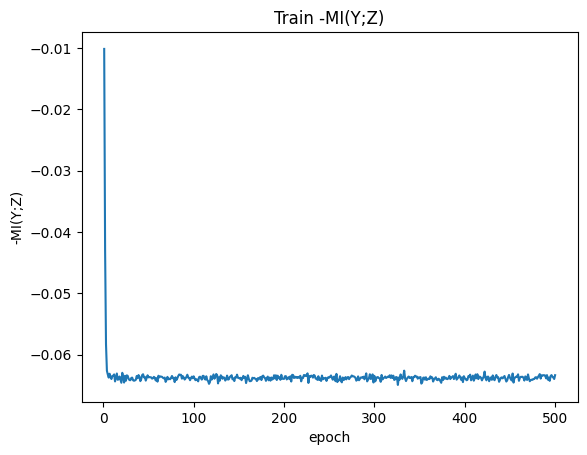

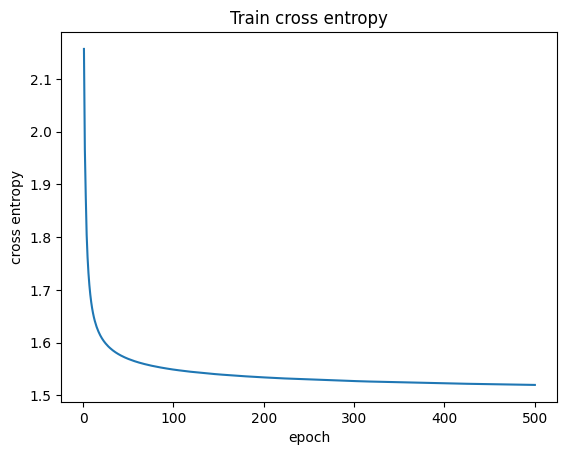

In [ ]:
plot_loss(layer1, num_epochs, loss_list[0])
plot_loss(layer2, num_epochs, loss_list[1])
plot_loss(fc1, num_epochs, loss_list[2])
plot_loss(fc2, num_epochs, loss_list[3])

# Flatten Statistical MINE

In [ ]:
def flatten_statistical_T_training(model, num_epochs, T, loss_list, layer_list, train_dataset):
    if len(train_dataset) < 1000:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
    else:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
  
    for param in model.parameters(): 
        param.requires_grad = False
  
    #training layer1
    print("Training layer1")
    for name, param in model.layer1.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[0]
    training_layer = layer_list[0]
    mine = Mine(T[0], method='concat').to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-6},
                                {"params": mine.parameters(), "lr": 1e-6}])
    layer1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.layer1.named_parameters():
        param.requires_grad = False

    #training layer2
    print("Training layer2")
    for name, param in model.layer2.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[1]
    training_layer = layer_list[1]
    mine = Mine(T[1], method='concat').to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-6},
                                {"params": mine.parameters(), "lr": 1e-6}])
    layer2 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.layer2.named_parameters():
        param.requires_grad = False

    #training fc1
    print("Training fc1")
    for name, param in model.fc1.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[2]
    training_layer = layer_list[2]
    mine = Mine(T[2], method='concat').to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-6},
                                {"params": mine.parameters(), "lr": 1e-6}])
    fc1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.fc1.named_parameters():
        param.requires_grad = False

    #training fc2
    print("Training fc2")
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
    for name, param in model.fc2.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[3]
    training_layer = layer_list[3]
    mine = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    fc2, train_acc, test_acc = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval=True)
    for name, param in model.fc2.named_parameters():
        param.requires_grad = False
    return layer1, layer2, fc1, fc2, train_acc, test_acc

In [ ]:
model = ConvNet_Layer().to(device)
T_estimator = [StatisticsNetwork(28*28, 16*14*14, device), StatisticsNetwork(28*28, 32*7*7, device), StatisticsNetwork(1, 256, device)]
loss_list = ['-MI(X;Z)', '-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ["layer1", "layer2", 'fc1', 'fc2']
num_epochs = 500
layer1, layer2, fc1, fc2, _, _ = flatten_statistical_T_training(model, num_epochs, T_estimator, loss_list, layer_list, train_dataset)

Training layer1
Epoch [1/500], layer1 -MI(X;Z) : 0.050569690174
Epoch [2/500], layer1 -MI(X;Z) : 0.051220915467
Epoch [3/500], layer1 -MI(X;Z) : 0.054181009904
Epoch [4/500], layer1 -MI(X;Z) : 0.048618990090
Epoch [5/500], layer1 -MI(X;Z) : 0.050084067074
Epoch [6/500], layer1 -MI(X;Z) : 0.053062031977
Epoch [7/500], layer1 -MI(X;Z) : 0.051953494456
Epoch [8/500], layer1 -MI(X;Z) : 0.048840976475
Epoch [9/500], layer1 -MI(X;Z) : 0.051541977407
Epoch [10/500], layer1 -MI(X;Z) : 0.052667431533
Epoch [11/500], layer1 -MI(X;Z) : 0.052317252010
Epoch [12/500], layer1 -MI(X;Z) : 0.048773049377
Epoch [13/500], layer1 -MI(X;Z) : 0.054694738053
Epoch [14/500], layer1 -MI(X;Z) : 0.050900365071
Epoch [15/500], layer1 -MI(X;Z) : 0.051834028121
Epoch [16/500], layer1 -MI(X;Z) : 0.049202858641
Epoch [17/500], layer1 -MI(X;Z) : 0.048091701015
Epoch [18/500], layer1 -MI(X;Z) : 0.052384105946
Epoch [19/500], layer1 -MI(X;Z) : 0.052172149500
Epoch [20/500], layer1 -MI(X;Z) : 0.049556471423
Epoch [21/500

In [ ]:
plot_loss(layer1, num_epochs, loss_list[0])
plot_loss(layer2, num_epochs, loss_list[1])
plot_loss(fc1, num_epochs, loss_list[2])
plot_loss(fc2, num_epochs, loss_list[3])

# Convolutional Statistical MINE

In [ ]:
def convolutional_T_training(model, num_epochs, T, loss_list, layer_list, train_dataset):
    if len(train_dataset) < 1000:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
    else:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)

    for param in model.parameters(): 
        param.requires_grad = False
  
    #training layer1
    print("Training layer1")
    for name, param in model.layer1.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[0]
    training_layer = layer_list[0]
    mine = Mine(T[0]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-5}])
    layer1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.layer1.named_parameters():
        param.requires_grad = False

    #training layer2
    print("Training layer2")
    for name, param in model.layer2.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[1]
    training_layer = layer_list[1]
    mine = Mine(T[1]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-5}])
    layer2 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.layer2.named_parameters():
        param.requires_grad = False

    #training fc1
    print("Training fc1")
    for name, param in model.fc1.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[2]
    training_layer = layer_list[2]
    mine = Mine(T[2]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-5}])
    fc1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.fc1.named_parameters():
        param.requires_grad = False

    #training fc2
    print("Training fc2")
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
    for name, param in model.fc2.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[3]
    training_layer = layer_list[3]
    mine = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    fc2, train_acc, test_acc = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval=True)
    for name, param in model.fc2.named_parameters():
        param.requires_grad = False
    return layer1, layer2, fc1, fc2, train_acc, test_acc

Training layer1
Epoch [1/500], layer1 -MI(X;Z) : 0.000077344353
Epoch [2/500], layer1 -MI(X;Z) : -0.017479828248
Epoch [3/500], layer1 -MI(X;Z) : -0.024318841534
Epoch [4/500], layer1 -MI(X;Z) : -0.026172842272
Epoch [5/500], layer1 -MI(X;Z) : -0.026539604863
Epoch [6/500], layer1 -MI(X;Z) : -0.026714651535
Epoch [7/500], layer1 -MI(X;Z) : -0.026673873017
Epoch [8/500], layer1 -MI(X;Z) : -0.026593551909
Epoch [9/500], layer1 -MI(X;Z) : -0.026702967286
Epoch [10/500], layer1 -MI(X;Z) : -0.026601415997
Epoch [11/500], layer1 -MI(X;Z) : -0.026745892502
Epoch [12/500], layer1 -MI(X;Z) : -0.026742453004
Epoch [13/500], layer1 -MI(X;Z) : -0.026681617647
Epoch [14/500], layer1 -MI(X;Z) : -0.026688476652
Epoch [15/500], layer1 -MI(X;Z) : -0.026821423136
Epoch [16/500], layer1 -MI(X;Z) : -0.026659192269
Epoch [17/500], layer1 -MI(X;Z) : -0.026594536006
Epoch [18/500], layer1 -MI(X;Z) : -0.026695779214
Epoch [19/500], layer1 -MI(X;Z) : -0.026725991753
Epoch [20/500], layer1 -MI(X;Z) : -0.0267017

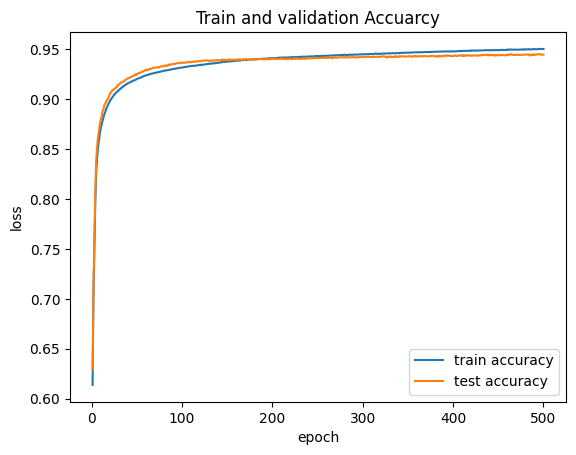

In [ ]:
model = ConvNet_Layer().to(device)
T_estimator = [ConvolutionalStatisticsNetwork(1, 16*14*14), ConvolutionalStatisticsNetwork(1, 32*7*7), T(1, 256)]
loss_list = ['-MI(X;Z)', '-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ["layer1", "layer2", 'fc1', 'fc2']
num_epochs = 500
layer1, layer2, fc1, fc2, _, _ = convolutional_T_training(model, num_epochs, T_estimator, loss_list, layer_list, train_dataset)

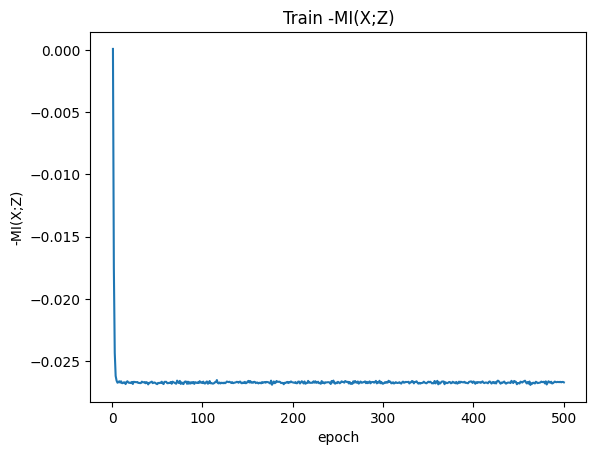

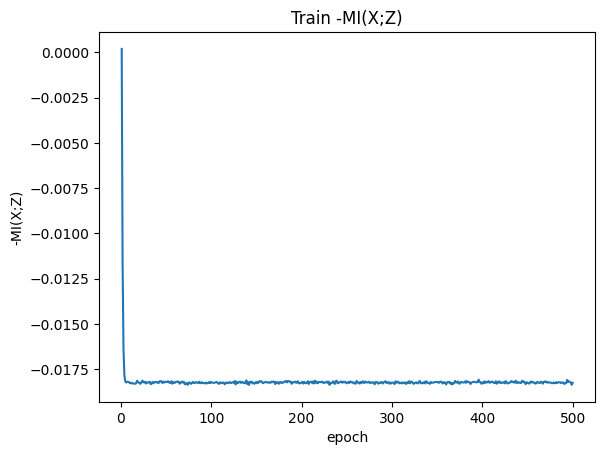

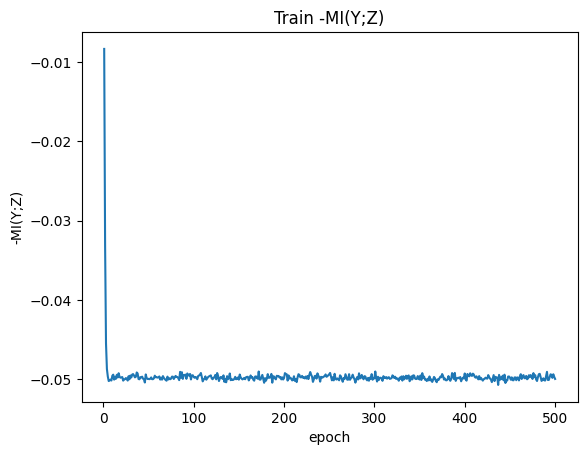

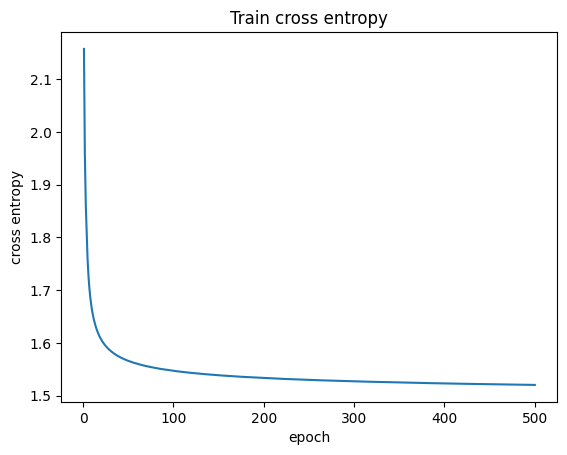

In [ ]:
plot_loss(layer1, num_epochs, loss_list[0])
plot_loss(layer2, num_epochs, loss_list[1])
plot_loss(fc1, num_epochs, loss_list[2])
plot_loss(fc2, num_epochs, loss_list[3])

# Double Convolutional Statistical MINE

In [ ]:
def Dconvolutional_T_training(model, num_epochs, T, loss_list, layer_list, train_dataset):
    if len(train_dataset) < 1000:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
    else:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
  
    for param in model.parameters(): 
        param.requires_grad = False
  
    #training layer1
    print("Training layer1")
    for name, param in model.layer1.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[0]
    training_layer = layer_list[0]
    mine = Mine(T[0]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-6},
                                {"params": mine.parameters(), "lr": 1e-6}])
    layer1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.layer1.named_parameters():
        param.requires_grad = False

    #training layer2
    print("Training layer2")
    for name, param in model.layer2.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[1]
    training_layer = layer_list[1]
    mine = Mine(T[1]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-6},
                                {"params": mine.parameters(), "lr": 1e-6}])
    layer2 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.layer2.named_parameters():
        param.requires_grad = False

    #training fc1
    print("Training fc1")
    for name, param in model.fc1.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[2]
    training_layer = layer_list[2]
    mine = Mine(T[2]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-6},
                                {"params": mine.parameters(), "lr": 1e-6}])
    fc1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.fc1.named_parameters():
        param.requires_grad = False

    #training fc2
    print("Training fc2")
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
    for name, param in model.fc2.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[3]
    training_layer = layer_list[3]
    mine = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    fc2, train_acc, test_acc = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval=True)
    for name, param in model.fc2.named_parameters():
        param.requires_grad = False
    return layer1, layer2, fc1, fc2, train_acc, test_acc

Training layer1
Epoch [1/500], layer1 -MI(X;Z) : -0.003646189114
Epoch [2/500], layer1 -MI(X;Z) : -0.016704997172
Epoch [3/500], layer1 -MI(X;Z) : -0.022960721608
Epoch [4/500], layer1 -MI(X;Z) : -0.024707893655
Epoch [5/500], layer1 -MI(X;Z) : -0.025204988041
Epoch [6/500], layer1 -MI(X;Z) : -0.025315259397
Epoch [7/500], layer1 -MI(X;Z) : -0.025334473451
Epoch [8/500], layer1 -MI(X;Z) : -0.025418681030
Epoch [9/500], layer1 -MI(X;Z) : -0.025263804694
Epoch [10/500], layer1 -MI(X;Z) : -0.025309010192
Epoch [11/500], layer1 -MI(X;Z) : -0.025278622750
Epoch [12/500], layer1 -MI(X;Z) : -0.025440542493
Epoch [13/500], layer1 -MI(X;Z) : -0.025342762563
Epoch [14/500], layer1 -MI(X;Z) : -0.025347784938
Epoch [15/500], layer1 -MI(X;Z) : -0.025320733245
Epoch [16/500], layer1 -MI(X;Z) : -0.025353805938
Epoch [17/500], layer1 -MI(X;Z) : -0.025326179061
Epoch [18/500], layer1 -MI(X;Z) : -0.025346429398
Epoch [19/500], layer1 -MI(X;Z) : -0.025383879151
Epoch [20/500], layer1 -MI(X;Z) : -0.025411

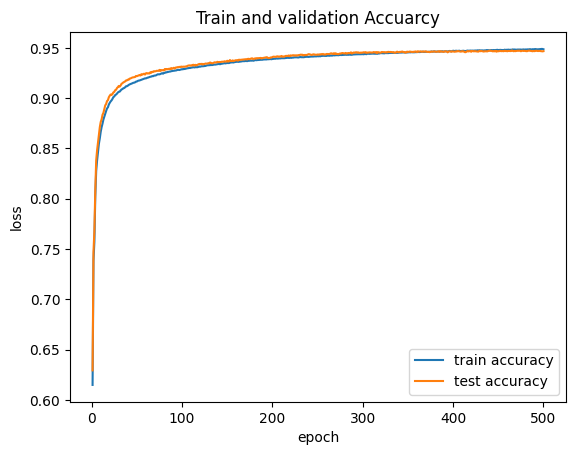

In [ ]:
model = ConvNet_Layer().to(device)
T_estimator = [DoubleConvolutionalStatisticsNetwork_layer1(1, 16), DoubleConvolutionalStatisticsNetwork_layer2(1, 32), T(1, 256)]
loss_list = ['-MI(X;Z)', '-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ["layer1", "layer2", 'fc1', 'fc2']
num_epochs = 500
layer1, layer2, fc1, fc2, _, _ = Dconvolutional_T_training(model, num_epochs, T_estimator, loss_list, layer_list, train_dataset)

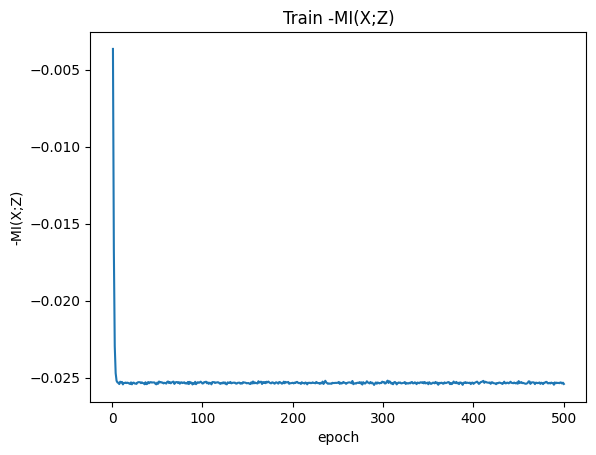

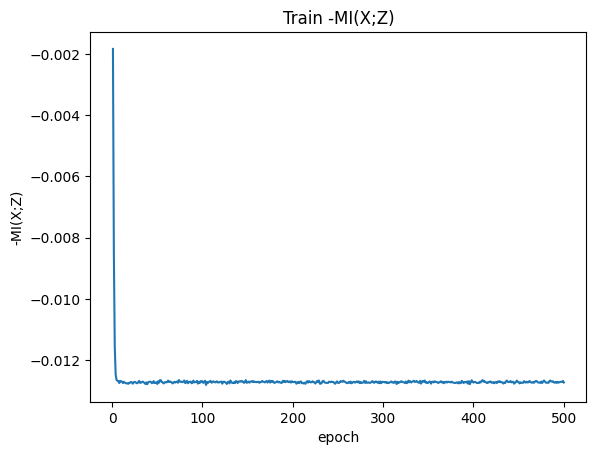

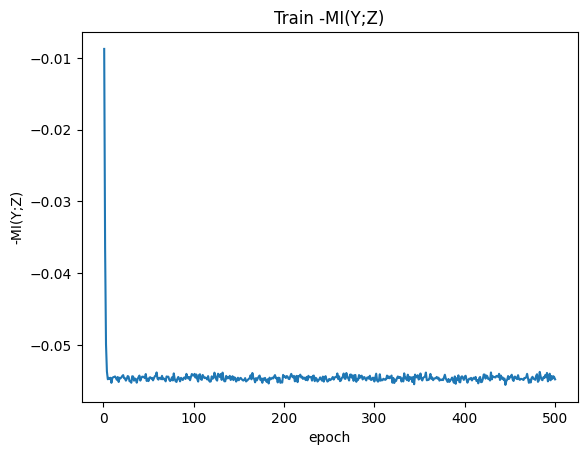

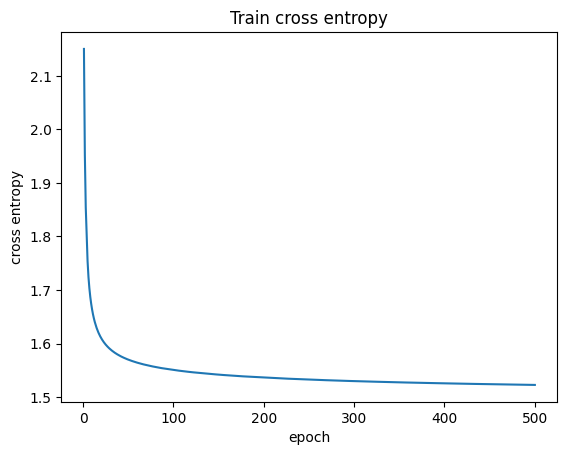

In [ ]:
plot_loss(layer1, num_epochs, loss_list[0])
plot_loss(layer2, num_epochs, loss_list[1])
plot_loss(fc1, num_epochs, loss_list[2])
plot_loss(fc2, num_epochs, loss_list[3])